# Lab 2.2: Hypothesis Testing

In Lab 2.1, we were addressing the following question:

Question: Consider the peak flow time series for Skykomish River. Postulating a change in flood statistics around 1975, test for statistical significance of the observed change in the mean annual flood. 

We used a two-sample test, with alpha=0.05 (i.e. 95% confidence) and the z-distribution to define the rejection region (why is this appropriate?).

Now, we want to use Monte Carlo simulations to check some of the underlying assumptions of that test.  This is simlar to Homework 2, Problem 2.

## Import and Sort Data
First, import modules for the whole lab and create useable arrays of data.

In [1]:
# Import all modules for the lab

# To load data
import pandas as pd

# To plot
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import math
import scipy.stats as st
import statistics as stats
from scipy.interpolate import interp1d

In [2]:
# Define the location of the .xlsx file.
Skykomish_data_file = 'Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'

# Use pandas.read_excel() function to open this file.
Skykomish_data = pd.read_excel(Skykomish_data_file)

# Now we can see the dataset we loaded:
Skykomish_data

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08
3,1932-02-26,1932,83300,20.70
4,1932-11-13,1933,72500,19.50
...,...,...,...,...
76,2005-01-18,2005,74600,19.55
77,2005-12-24,2006,33800,14.27
78,2006-11-06,2007,129000,24.51
79,2007-12-03,2008,51100,16.79


In [3]:
# Divide the data into the early period (before 1975) and late period
# (after and including 1975). 
Skykomish_early = Skykomish_data[ Skykomish_data['water year'] < 1975 ] 
Skykomish_late = Skykomish_data[ Skykomish_data['water year'] >= 1975 ] 

## In Lab 2.1, we found that our data might have a log-normal distribution, but we weren't sure.



* In this lab, we will create quantile plots using the actual data and then use a random number generator to draw data from that distribution (as represented by the actual data in its quantile plot.

In [4]:
# Calculate quantiles of the early data

# The function takes an array of data as an argument and returns the data
# as an ordered array and the plotting position associated with each data point.
def quantile_fn(data):

    ordered_data = np.sort(data)
    n = len(ordered_data)

    rank = []
    plotting_position = []
    for i in range(n):
        rank.append(i+1)
        # Using the Cunnane plotting position.
        plotting_position.append((rank[i]-.4)/(n+.2))
        
    return ordered_data, plotting_position


In [5]:
# Calculate CDF from entire record

x_ordered, x_plotting = quantile_fn(Skykomish_data['peak value (cfs)'])
x_CDF = [1 - i for i in x_plotting]

x_ordered = np.flip(x_ordered, 0)

# Extrapolate the ends so that the distribution goes all the way from 0 to 1
xsort_first = x_ordered[0] + (x_ordered[0]-x_ordered[1]) * (1-x_CDF[0])/(x_CDF[0]-x_CDF[1])
xsort_last = x_ordered[len(x_ordered)-1] - (x_ordered[len(x_ordered)-1] - x_ordered[len(x_ordered)-2]) * x_CDF[len(x_CDF)-1]/(x_CDF[len(x_CDF)-1]- x_CDF[len(x_CDF)-2])
xsort = [xsort_first]
xsort.extend(x_ordered)
xsort.append(xsort_last)

x_CDF.insert(0, 1)
x_CDF.append(0)

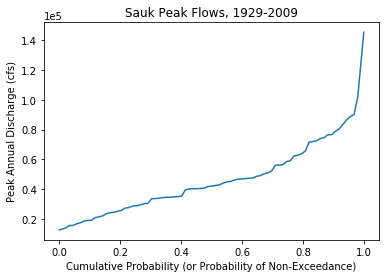

In [6]:
# Plot

plt.figure()
plt.plot(x_CDF, xsort)
plt.ylabel('Peak Annual Discharge (cfs)')
plt.xlabel('Cumulative Probability (or Probability of Non-Exceedance)')
plt.title('Sauk Peak Flows, 1929-2009')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

---
Now, our goal is to generate random data, drawn from this distribution, and check if the distribution of the means of these random datasets is normally distributed.  

Then we want to extract the mean value that falls at the 95th percentile of the distribution of the means.  There is only a 5% chance that a mean value would randomly fall above that if picked from the same distribution.

In [7]:
# first, what's the best function to use?
np.random.random_sample?

In [8]:
interp1d?

In [9]:
# Generate 100 sets of 20 random numbers

q = np.random.random_sample((100, 20))

# Map to the CDF of our data, this says to look up the x_CDF value and see what actual 
# streamflow value (xsort) corresponds to it
f = interp1d(x_CDF, xsort) # create a function
Q = f(q) # evaluate the function with random values q
   

# It's a good idea to check that you have the right axis here.  
# We want 100 means of 20 numbers each, but if we look at the wrong axis of the matrix, 
# we could get 20 means of 100 numbers each.
Q_mean = np.mean(Q, axis=1)

#here is my printing to check
print(len(Q_mean))

Q_sd = np.std(Q, axis=1)

100


In [10]:
## We can even plot our randomly generated CDFs if you uncomment this section
#f, ax = plt.subplots(4,5,figsize=(10,7))
#s=0
#for r in range(0,4):
#    for c in range(0,5):
#        ax[r,c].plot(x_CDF, xsort, '-r') # plot the underlying CDF
#        ax[r,c].plot(q[:,s],Q[:,s],'.k') # plot the random points we've mapped to the CDF
#        s+=1
#f.tight_layout() 

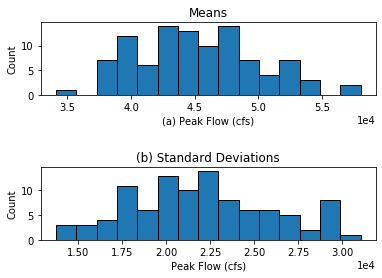

In [11]:
# Plot histograms

fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1)
nbins = 15

axs[0].hist(Q_mean, nbins, ec="black")
axs[0].set_title('Means')
axs[0].set_xlabel('(a) Peak Flow (cfs)')
axs[0].set_ylabel('Count')
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

axs[1].hist(Q_sd, nbins, ec="black")
axs[1].set_title('(b) Standard Deviations')
axs[1].set_xlabel('Peak Flow (cfs)')
axs[1].set_ylabel('Count')
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

#### Looking at the graph above, the means look roughly normally distributed, but the standard deviations do not look normally distributed.  This is what we would expect based on the Central Limit Theorem.

---
#### Next, determine the mean peak flow value above which only 5% of a random set of 20 numbers from the basic distribution would fall into.
To do this, take the 100 Q_mean values you just calculated, and use the Cunnane-quantile method to plot them on a CDF.  Then, look up what Q_mean value corresponds to the 0.95 value on the CDF.

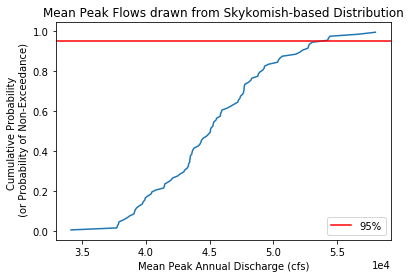

In [12]:
Qmean_ordered, Qmean_plotting = quantile_fn(Q_mean)

plt.figure()
plt.plot(Qmean_ordered, Qmean_plotting,label='')
plt.xlabel('Mean Peak Annual Discharge (cfs)')
plt.ylabel('Cumulative Probability \n (or Probability of Non-Exceedance)')
plt.title('Mean Peak Flows drawn from Skykomish-based Distribution')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.axhline(0.95,color='red',label='95%')
plt.legend()


In [13]:
# Now use the interpolation function to "look-up" what Q-value that is at the intersection of
# our two lines in the graph above.
f2 = interp1d(Qmean_plotting, Qmean_ordered)
print(f2(0.95))

53781.673729938964


## What have we learned from this exercise?
#### By brute force, we can see that there is only a 5% chance that 20 numbers drawn randomly from this specific distribution would be larger than the number printed above.  Therefore, if we had 20 observed values and calculated their mean, we would be 95% confidence that a mean of this value or larger actually came from a true distribution with a larger mean than that of our original distribution.